### DMA Assignment 3
#### Final Model Assessment

In [ ]:
#!pip install catboost

In [1]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
#features selection and class imbalance
from imblearn.over_sampling import SMOTE
#machine learning models
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
#model performance evaluation
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import classification_report, accuracy_score

## Stage 1

After the initial model selection and parameter tuning, we decided that to predict if a session is a buying or non-buying, we will use XGBoost.

In [2]:
#load session level data 
session_train = pd.read_csv('final_session_level_train.csv')
session_test = pd.read_csv('final_session_level_test.csv')

In [3]:
session_train

,Unnamed: 0,Session ID,num_clicks_session,buy_flag,session_length,Avg_time_bet_clicks,Max_time_bet_clicks,unique_items,max_click_per_item,max_hour,max_day,max_month,Avg_item_price,Popularity,perc_prod_offer,perc_prod_no_cat,perc_prod_pop
0,0,1,4,False,351.0,116.666667,180.0,4,1,10,0,4,2669.000000,0.020006,0.0,1.0,0.5
1,1,2,6,False,359.0,71.400000,118.0,5,2,14,0,4,2382.333333,0.006365,0.0,1.0,0.8
2,2,3,3,False,745.0,372.000000,495.0,3,1,13,2,4,4701.595023,0.026714,0.0,1.0,0.0
3,3,4,2,False,1034.0,1034.000000,1034.0,2,1,12,0,4,20315.500000,0.006692,0.0,1.0,0.5
4,4,6,2,False,246.0,246.000000,246.0,2,1,17,6,4,6336.696891,0.025385,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7710262,7710320,9737847,3,False,249.0,124.500000,161.0,2,2,11,2,8,2512.000000,0.040977,1.0,0.0,0.0
7710263,7710321,9737846,3,False,72.0,36.000000,47.0,2,2,19,4,8,3734.000000,0.033367,1.0,0.0,0.0
7710264,7710322,9737841,2,False,226.0,226.000000,226.0,2,1,18,2,8,17698.000000,0.013623,0.0,0.0,0.5
7710265,7710323,9737843,4,True,1447.0,482.000000,977.0,2,2,19,6,8,836.500000,0.060103,1.0,0.0,0.0


In [4]:
#preprocessing data 
session_train['buy_flag'] = (session_train['buy_flag'] == True).astype(int)
#session_train['buy_flag'] = (session_train['buy_flag'] == False).astype(int)

session_test['buy_flag'] = (session_test['buy_flag'] == True).astype(int)
#session_test['buy_flag'] = (session_test['buy_flag'] == False).astype(int)

session_train_data = session_train.drop(["Unnamed: 0","buy_flag", "unique_items", "Session ID"], axis=1)
session_train_y = session_train["buy_flag"]

session_test_data = session_test.drop(["Unnamed: 0", "buy_flag", "unique_items", "Session ID"], axis=1)
session_test_ID = session_test[["Session ID"]]
session_test_y = session_test["buy_flag"] 

In [5]:
session_train['buy_flag'].sum()

428585

In [6]:
session_test_data

,num_clicks_session,session_length,Avg_time_bet_clicks,Max_time_bet_clicks,max_click_per_item,max_hour,max_day,max_month,Avg_item_price,Popularity,perc_prod_offer,perc_prod_no_cat,perc_prod_pop
0,4,71.0,23.333333,28.0,1,23,6,9,529.798246,0.067234,1.000000,0.0,0.0
1,13,1263.0,104.666667,454.0,2,23,6,9,732.000000,0.147200,1.000000,0.0,0.0
2,3,283.0,141.000000,184.0,1,23,6,9,993.500000,0.063096,1.000000,0.0,0.0
3,55,48575.0,899.018519,1054.0,55,23,6,9,0.000000,0.011905,0.000000,0.0,0.0
4,10,5066.0,562.555556,2123.0,7,23,6,9,10471.000000,0.052124,0.250000,0.0,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1539457,6,851.0,169.800000,358.0,4,16,2,9,0.000000,0.000000,0.666667,0.0,0.0
1539458,1,0.0,0.000000,0.0,1,16,0,9,0.000000,0.000000,1.000000,0.0,0.0
1539459,1,0.0,0.000000,0.0,1,15,5,9,0.000000,0.000000,0.000000,1.0,0.0
1539460,4,949.0,316.333333,630.0,1,9,3,9,0.000000,0.000000,1.000000,0.0,0.0


<AxesSubplot:xlabel='buy_flag', ylabel='count'>

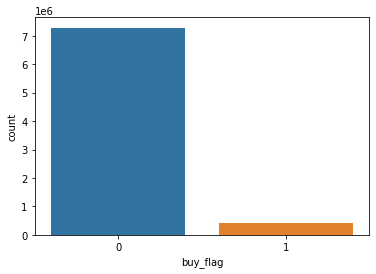

In [7]:
sns.countplot(x = 'buy_flag', data=session_train)

In [8]:
from xgboost import XGBClassifier
## Tuned model
XGB_model = XGBClassifier(objective='binary:logistic', n_estimators = 50, booster = 'gblinear',
                          scale_pos_weight = 18, n_jobs=-1, learning_rate = 1, alpha = 0.1,
                          #we need to account for imbalance class ratio 1:17.98 using scale_pos_weight
                          use_label_encoder =False, eval_metric = 'auc')

XGB_model.fit(session_train_data, session_train_y)
XGB_model_predict = XGB_model.predict(session_test_data)
XGB_model


XGBClassifier(alpha=0.1, base_score=0.5, booster='gblinear',
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, eval_metric='auc', gamma=None, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=1, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=-1, num_parallel_tree=None,
              random_state=0, reg_alpha=0, reg_lambda=0, scale_pos_weight=18,
              subsample=None, tree_method=None, use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [9]:
print('XGB Test Accuracy:', accuracy_score(session_test_y, XGB_model_predict), '\n')
print(classification_report(session_test_y, XGB_model_predict))
print(confusion_matrix(session_test_y, XGB_model_predict), '\n')


XGB Test Accuracy: 0.7438169958076263 

              precision    recall  f1-score   support

           0       0.97      0.75      0.85   1458351
           1       0.13      0.64      0.21     81111

    accuracy                           0.74   1539462
   macro avg       0.55      0.70      0.53   1539462
weighted avg       0.93      0.74      0.81   1539462

[[1092827  365524]
 [  28860   52251]] 



In [10]:
final_q1_prediction = pd.concat([session_test_ID, session_test_y, pd.Series(XGB_model_predict)], axis=1)
final_q1_prediction = final_q1_prediction.rename(columns={0: 'buy_predict'})
final_q1_prediction

,Session ID,buy_flag,buy_predict
0,9298581,0,0
1,9302326,0,1
2,9280258,0,0
3,9281918,0,1
4,9258974,1,1
...,...,...,...
1539457,11299813,0,1
1539458,11299814,0,0
1539459,11299808,0,0
1539460,11299809,0,1


## Stage 2

As dicussed, we selected CatBoost for classifying items being bought in buy sessions. Test data from Stage 1 is being used as test dataset for Stage 2 so, sessions predicted in Stage 1 as buying sessions were used to test the CatBoostclassifier performance

In [11]:
#load item level data
item_train = pd.read_csv("Item_level_train.csv")
item_test = pd.read_csv("Item_level_test.csv")

In [12]:
#filter all sessions that were identified as buy from question 1
session_ind = list(final_q1_prediction["Session ID"].loc[final_q1_prediction['buy_predict'] == 1])
item_test = item_test.loc[item_test["Session ID"].isin(session_ind)]

<AxesSubplot:xlabel='Item_Bought_flag', ylabel='count'>

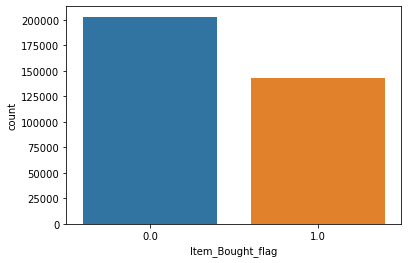

In [13]:
#eda - check if we need to account for class weight
sns.countplot(x = "Item_Bought_flag", data=item_test)

In [14]:
item_test['Item_Bought_flag'].value_counts()

0.0    202916
1.0    143138
Name: Item_Bought_flag, dtype: int64

In [15]:
#data preprocessing 
#add dummy columns for categorical data
item_train = pd.get_dummies(item_train, columns = ["Category_flag"])
item_test = pd.get_dummies(item_test, columns = ["Category_flag"])
#drop unnecessary columns
item_train = item_train.drop("Unnamed: 0", axis=1)
item_test = item_test.drop("Unnamed: 0", axis=1)

item_train_data = item_train.drop(["Item_Bought_flag", "Session ID", "Item ID"], axis=1)
item_train_y = item_train["Item_Bought_flag"]

item_test_data = item_test.drop(["Item_Bought_flag", "Session ID", "Item ID"], axis=1)
item_test_ID = item_test[["Session ID", "Item ID"]]
item_test_y = item_test["Item_Bought_flag"]

In [16]:
#run model 
ctb = CatBoostClassifier(eval_metric='AUC', learning_rate=0.2, iterations=50, scale_pos_weight=1.2)
ctb.fit(item_train_data, item_train_y)
y_pred = ctb.predict(item_test_data)
tn, fp, fn, tp = confusion_matrix(item_test_y, y_pred).ravel()
(tn, fp, fn, tp)

0:	total: 367ms	remaining: 18s
1:	total: 556ms	remaining: 13.4s
2:	total: 741ms	remaining: 11.6s
3:	total: 927ms	remaining: 10.7s
4:	total: 1.1s	remaining: 9.94s
5:	total: 1.29s	remaining: 9.48s
6:	total: 1.48s	remaining: 9.06s
7:	total: 1.65s	remaining: 8.67s
8:	total: 1.84s	remaining: 8.4s
9:	total: 2.01s	remaining: 8.05s
10:	total: 2.19s	remaining: 7.75s
11:	total: 2.38s	remaining: 7.53s
12:	total: 2.56s	remaining: 7.3s
13:	total: 2.75s	remaining: 7.07s
14:	total: 2.93s	remaining: 6.83s
15:	total: 3.12s	remaining: 6.64s
16:	total: 3.31s	remaining: 6.44s
17:	total: 3.49s	remaining: 6.21s
18:	total: 3.69s	remaining: 6.02s
19:	total: 3.88s	remaining: 5.82s
20:	total: 4.08s	remaining: 5.63s
21:	total: 4.26s	remaining: 5.42s
22:	total: 4.46s	remaining: 5.24s
23:	total: 4.64s	remaining: 5.03s
24:	total: 4.82s	remaining: 4.82s
25:	total: 5.01s	remaining: 4.62s
26:	total: 5.17s	remaining: 4.41s
27:	total: 5.38s	remaining: 4.23s
28:	total: 5.57s	remaining: 4.04s
29:	total: 5.76s	remaining: 3

(139621, 63295, 24648, 118490)

In [17]:
print(classification_report(item_test_y, y_pred))
tn, fp, fn, tp = confusion_matrix(item_test_y, y_pred).ravel()
(tn, fp, fn, tp)

              precision    recall  f1-score   support

         0.0       0.85      0.69      0.76    202916
         1.0       0.65      0.83      0.73    143138

    accuracy                           0.75    346054
   macro avg       0.75      0.76      0.74    346054
weighted avg       0.77      0.75      0.75    346054



(139621, 63295, 24648, 118490)

In [18]:
clustersDf = pd.DataFrame(y_pred)
clustersDf.columns = ['item_predict']
item_test_ID = item_test_ID.reset_index()
item_test_y = item_test_y.reset_index()
combinedDf = pd.concat([item_test_ID, item_test_y, clustersDf], axis = 1)
combinedDf

,index,Session ID,Item ID,index,Item_Bought_flag,item_predict
0,1,9293662,214677615,1,1.0,1.0
1,3,9293797,214663310,3,0.0,1.0
2,4,9293797,214822082,4,1.0,1.0
3,5,9293797,214854060,5,0.0,1.0
4,6,9293797,214854118,6,0.0,1.0
...,...,...,...,...,...,...
346049,407811,11299794,214854815,407811,0.0,1.0
346050,407812,11299794,214854731,407812,0.0,1.0
346051,407813,11299794,214854767,407813,0.0,1.0
346052,407814,11299794,214854542,407814,0.0,1.0


### Session Score - Evaluation Measure

According to the predicted sessions and items bought predictions, score is calculated as follows -

1. the Jaccard score is computed between the predicted and the actual set of bought items 
2. For each session which is included in the test file, we are adding the ratio of buying sessions to overall sessions and subtracting in case the challenger predicts that a session ends with buying events while in reality it didn’t as a penalty to the overall score in case the session comprises a buying event in reality

In [19]:
valid_purchase=final_q1_prediction.copy()
valid_item = combinedDf.copy()
valid_item =valid_item.rename(columns={'Session ID':'session_id','Item_Bought_flag': 'target', 'Item ID':'item_id','item_predict': 'prediction'})
valid_purchase = valid_purchase.rename(columns={'Session ID':'session_id','buy_flag': 'target', 'buy_predict': 'prediction'})

Jaccard distance for item level prediction

In [20]:
def jaccard_by_thresh():
    valid_item['decision'] = valid_item['prediction'] 
    #valid_item['target'] = valid_item['target'] == 1
    valid_item['union'] = (valid_item['target']==1) | (valid_item['decision']==1)
    valid_item['intersection'] = (valid_item['target']==1) & (valid_item['decision']==1)
    union_and_intersection = valid_item.loc[:, ['session_id', 'union', 'intersection']].groupby('session_id').sum()
    jaccard = union_and_intersection['intersection'].astype(float) / union_and_intersection['union']
    jaccard.name = 'jaccard'
    return jaccard

In [21]:
jaccard = jaccard_by_thresh()
valid_purchase_items = valid_purchase.join(jaccard, on='session_id', how='left').fillna(0)

In [105]:
valid_purchase_items[valid_purchase_items['session_id']==9293797]

,session_id,target,prediction,jaccard
93,9293797,1,1,0.333333


In [104]:
valid_item[valid_item['session_id']==9293797]
#valid_item[valid_item['union']== ]

,index,session_id,item_id,index,target,prediction,decision,union,intersection
1,3,9293797,214663310,3,0.0,1.0,1.0,True,False
2,4,9293797,214822082,4,1.0,1.0,1.0,True,True
3,5,9293797,214854060,5,0.0,0.0,0.0,False,False
4,6,9293797,214854118,6,0.0,1.0,1.0,True,False


In [22]:
purchase_actual = valid_purchase['target']
purchase_predicted = valid_purchase['prediction']
print ('Positive: actual %.2f%%, predicted %.2f%%' % (purchase_actual.mean() * 100, purchase_predicted.mean() * 100))

Positive: actual 5.27%, predicted 27.14%


In [23]:
item_actual = valid_item['target']
item_predicted = valid_item['prediction'] 
print ('Positive: actual %.2f%%, predicted %.2f%%' % (item_actual.mean() * 100, item_predicted.mean() * 100))

Positive: actual 41.36%, predicted 52.53%


In [26]:
purchase_tp = (purchase_actual & purchase_predicted).sum()
purchase_fp = ((1 - purchase_actual) & purchase_predicted).sum() 
score_tpfp = (float(purchase_actual.sum()) / purchase_actual.shape[0]) * (purchase_tp - purchase_fp)
score_jaccard = valid_purchase_items.loc[:, 'jaccard'].sum()
score = score_tpfp + score_jaccard

purchase_max_tp = purchase_actual.sum()
purchase_max_fp = 0
score_max_tpfp = (float(purchase_actual.sum()) / purchase_actual.shape[0]) * (purchase_max_tp - purchase_max_fp)
score_max_jaccard = purchase_actual.sum()
score_max = score_max_tpfp + score_max_jaccard

print ('Max achievable score: %10.2f = %.2f (max purchase) + %10.2f (max jaccard)' % (
    score_max, score_max_tpfp, score_max_jaccard) )
print ('Score gained:         %10.2f = %.2f (purchase)    + %10.2f (jaccard)' % (
    score, score_tpfp, score_jaccard))
print ('Gained percent: %.2f%%' % (score / score_max * 100))

Max achievable score:   85384.57 = 4273.57 (max purchase) +   81111.00 (max jaccard)
Score gained:           17627.31 = -16505.69 (purchase)    +   34133.01 (jaccard)
Gained percent: 20.64%


#### Summary:
 
We used both the logistic regression and XGBoost for predicting Buying sessions and calculating the score but XGBoost gave us better score so we selected that model for the predictions. Also, score achieved using the above models accounts for 20.64% of the maximum achievable score if we predicted all the sessions correctly.